# 五、手撕Normalization
在机器学习中，归一化（Normalization）能够加速网络收敛、缓解梯度消失/爆炸。 Z-score normalization为一种基础的归一化方法，即经过处理的数据符合标准正态分布，均值为 0，标准差为 1 。$$x_{\text{norm}}=\frac{x-\mu}{\sigma}$$

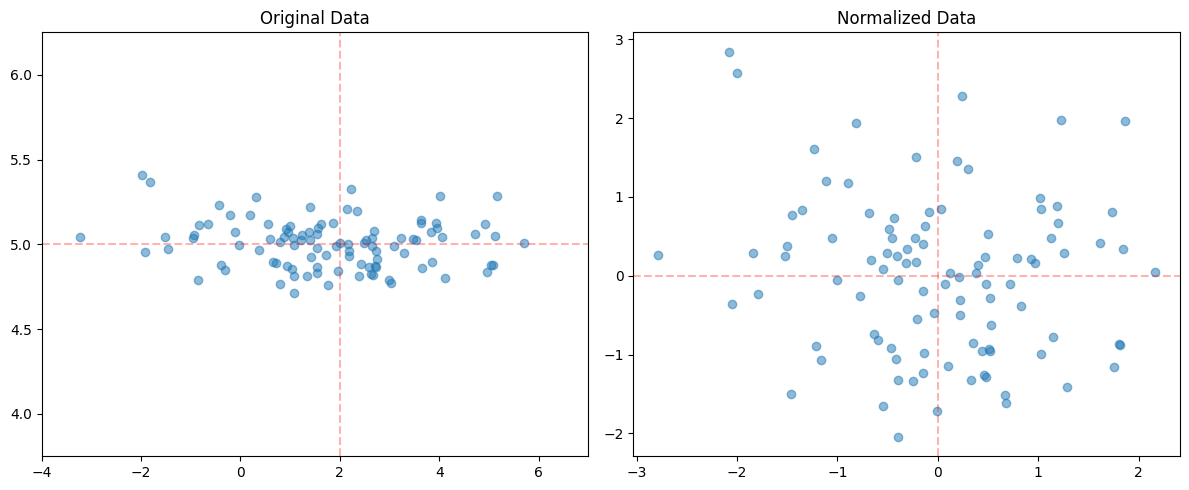

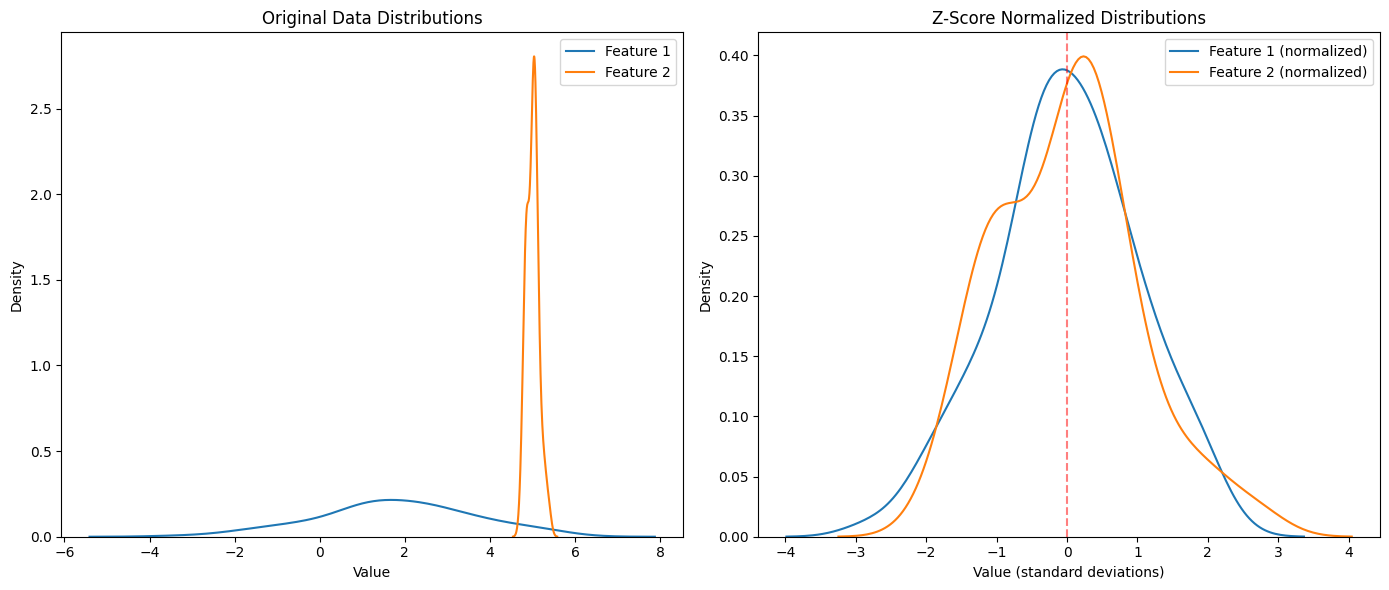

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 生成样本数据
n_samples = 100
np.random.seed(42)
x_center = 2
y_center = 5

# 创建两个特征
X = np.zeros((n_samples, 2))
X[:, 0] = np.random.normal(loc=x_center, scale=2, size=n_samples)
X[:, 1] = np.random.normal(loc=y_center, scale=0.15, size=n_samples)

# 进行z-score标准化
X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 绘制原始数据
ax1.scatter(X[:, 0], X[:, 1], alpha=0.5)
ax1.axvline(x=x_center, color='r', linestyle='--', alpha=0.3)
ax1.axhline(y=y_center, color='r', linestyle='--', alpha=0.3)
ax1.set_title('Original Data')
ax1.set_xlim(x_center-6, x_center+5)  # 设置x轴范围为5.5
ax1.set_ylim(y_center-6, y_center+5)   # 设置y轴范围为5.5
ax1.set_ylim(3.75, 6.25)   # 设置y轴范围为5.5

# 绘制标准化后的数据
ax2.scatter(X_normalized[:, 0], X_normalized[:, 1], alpha=0.5)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.3)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax2.set_title('Normalized Data')

plt.tight_layout()
plt.show()

# Optional: Create a distribution plot to show the effect of normalization
plt.figure(figsize=(14, 6))

# Original data distributions
plt.subplot(1, 2, 1)
sns.kdeplot(X[:, 0], label='Feature 1')
sns.kdeplot(X[:, 1], label='Feature 2')
plt.title('Original Data Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Normalized data distributions
plt.subplot(1, 2, 2)
sns.kdeplot(X_normalized[:, 0], label='Feature 1 (normalized)')
sns.kdeplot(X_normalized[:, 1], label='Feature 2 (normalized)')
plt.title('Z-Score Normalized Distributions')
plt.xlabel('Value (standard deviations)')
plt.ylabel('Density')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


在现代深度学习中，发展出了多种专门的归一化层，主要包括：

- BatchNorm：对于每个批次的数据在batch维度进行Z-score归一化
- LayerNorm：对每个样本在特征维度进行Z-score归一化
- RMSNorm：对每个样本在特征维度进行进行归一化，但只进行缩放（除以均方根），不做均值中心化

其中 BatchNorm、LayerNorm 属于典型的 Z-score 归一化（中心化 + 缩放），而RMSNorm 只做缩放（除以 RMS），不做中心化。这三种方法虽然都属于归一化技术，但在归一化的维度和具体操作上各有特点。

Dropout是现代深度学习网络中最常见的正则化组件（Regularization）, 其基本原理是在训练过程中随机丢弃一定比例的神经元，让模型不会过于依赖某些神经元，增强模型的泛化能力。

## 1. Layer Normalization
Layer Normalization(LN)不同于Batch Normalization，计算时不依赖batch size，只对每个样本独立地进行归一化。

公式：

$$
\begin{gathered}
\mu_L=\frac{1}{H}\sum_{i=1}^{H}x_{i} \\
\sigma_L^{2}=\frac{1}{H}\sum_{i=1}^H(x_i-\mu_L)^2 \\
\hat{x}_{i}=\frac{x_i-\mu_L}{\sqrt{\sigma_L^2+\epsilon}}
\end{gathered}
$$

其中$\mu_L$, $\sigma_L^2$分别是特征维度上的均值和方差，$\epsilon$是用于数值稳定的常数（一般为1e-5），$H$是特征维度的大小。

在归一化后，可以加入可学习的参数（仿射变换）：
$$y=\gamma \hat{x}_{i}+\beta$$

PyTorch的`nn.LayerNorm`使用参数`elementwise_affine`来控制是否使用仿射变换，默认值为`True`

> Transformer的encoder和decoder使用Layer Normalization

In [9]:
import torch
from torch import nn

class MyLayerNormalization(nn.Module):
    def __init__(self, normalized_size, eps=1e-5, elementwise_affine=True):
        super().__init__()
        self.normalized_shape = normalized_size
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        
        if self.elementwise_affine:
            # nn.Parameter: 可训练参数
            self.gamma = nn.Parameter(torch.ones(normalized_size))
            self.beta = nn.Parameter(torch.zeros(normalized_size))
        else:
            self.register_parameter('gamma', None)
            self.register_parameter('beta', None)
    
    def forward(self, x):   # 例：x.shape = [batch_size, seq_len, hidden_size]
        mu = x.mean(dim=-1, keepdim=True)                   # shape: [batch_size, seq_len, 1]
        # 计算总体方差而不是样本方差，所以unbiased=False
        var = x.var(dim=-1, keepdim=True, unbiased=False)   # shape: [batch_size, seq_len, 1]
        
        x_norm = (x - mu) / torch.sqrt(var+self.eps)
        if self.elementwise_affine:
            output = self.gamma * x_norm + self.beta
        else:
            output = x_norm
            
        return output                                      # shape: [batch_size, seq_len, 1]
    
# 测试数据
batch_size = 2
seq_len = 2
hidden_size = 4
x = torch.randn(batch_size, seq_len, hidden_size)
my_LN = MyLayerNormalization(hidden_size, elementwise_affine=True)
torch_LN = nn.LayerNorm(hidden_size, elementwise_affine=True)

print(f"Input:\n{x}\n")
print(f"My LN:\n{my_LN(x)}\n")
print(f"Pytorch LN: {torch_LN(x)}")

Input:
tensor([[[ 0.4559,  0.8315,  0.0238,  0.2286],
         [-1.3476,  1.0583,  1.1616, -0.0690]],

        [[-0.8751, -0.8553,  0.5554,  0.4941],
         [-1.4840, -0.5414, -0.1751,  0.5652]]])

My LN:
tensor([[[ 0.2368,  1.4898, -1.2050, -0.5215],
         [-1.5241,  0.8440,  0.9457, -0.2655]],

        [[-1.0137, -0.9852,  1.0435,  0.9554],
         [-1.4574, -0.1797,  0.3168,  1.3203]]], grad_fn=<AddBackward0>)

Pytorch LN: tensor([[[ 0.2368,  1.4898, -1.2050, -0.5215],
         [-1.5241,  0.8440,  0.9457, -0.2655]],

        [[-1.0137, -0.9852,  1.0435,  0.9554],
         [-1.4574, -0.1797,  0.3168,  1.3203]]],
       grad_fn=<NativeLayerNormBackward0>)


## 2. RMS Normalization
RMS Normalization 是一种简化的归一化方法，只进行缩放而不进行中心化，计算开销更小。

公式：

$$
\begin{gathered}
\text{RMS}(x)=\sqrt{\frac{1}{H}\sum_{i=1}^{H}x_i^2+\epsilon} \\
\hat{x}_i=\frac{x_i}{\text{RMS}(x)}
\end{gathered}
$$

其中$\text{RMS}(x)$是均方根，$\epsilon$是用于数值稳定的常数（一般为1e-5），$H$是特征维度的大小。

原本LN中的仿射变换 被替换为 线性变换（即丢弃偏移参数）：
$$y=\gamma \hat{x}_i$$

> LLaMA、PaLM等大语言模型使用RMS Normalization替代Layer Normalization，在保持性能的同时提升计算效率

In [12]:
import torch
from torch import nn

class MyRMSNormalization(nn.Module):
    def __init__(self, normalized_size, eps=1e-5, elementwise_affine=True):
        super().__init__()
        self.normalized_size = normalized_size
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        
        if self.elementwise_affine:
            self.gamma = nn.Parameter(torch.ones(self.normalized_size))
        else:
            self.register_parameter('gamma', None)
        
    def forward(self, x):    # 例：x.shape = [batch_size, seq_len, hidden_size]
        rms = torch.sqrt(torch.mean(x.pow(2), dim=-1, keepdim=True) + self.eps)  # shape: [batch_size, seq_len, 1]
        x_norm = x / rms
        if self.elementwise_affine:
            output = self.gamma * x_norm
        else:
            output = x_norm
        return output   # shape: [batch_size, seq_len, hidden_size]
    
batch_size = 2
seq_len = 2
hidden_size = 4
x = torch.randn(batch_size, seq_len, hidden_size)
my_rms = MyRMSNormalization(hidden_size)

print(f"Input:\n{x}\n")
print(f"RMS Norm:\n{my_rms(x)}")

Input:
tensor([[[-1.2220,  0.0823, -1.3327,  0.1768],
         [-0.1903,  0.2148, -0.4942,  0.5959]],

        [[ 0.5281,  0.0647, -1.4195,  0.2503],
         [-0.1105, -1.7692, -0.8360,  1.1030]]])

RMS Norm:
tensor([[[-1.3439,  0.0905, -1.4656,  0.1944],
         [-0.4610,  0.5204, -1.1971,  1.4434]],

        [[ 0.6875,  0.0842, -1.8477,  0.3258],
         [-0.0983, -1.5733, -0.7435,  0.9809]]], grad_fn=<MulBackward0>)


## 3. Batch Normalization
Batch Normalization(BN) 对每个批次的数据在batch维度进行归一化，

公式：

$$
\begin{gathered}
\mu_B=\frac{1}{m}\sum_{i=1}^{m}x_{i} \\
\sigma_B^{2}=\frac{1}{m}\sum_{i=1}^m(x_i-\mu_B)^2 \\
\hat{x}_{i}=\frac{x_i-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}
\end{gathered}
$$

其中$\mu_B$, $\sigma_B^2$分别是batch上的均值和方差，$\epsilon$是用于数值稳定的常数（一般为1e-5），$m$是batch size的大小。

在归一化后，可以加入可学习的参数（仿射变换）：
$y=\gamma \hat{x}_{i}+\beta$

PyTorch的`nn.BatchNorm1d/2d/3d`默认都使用仿射变换`affine=True`。

在实现代码时，训练和推理时的方差/均值计算有差异：

- 训练过程中，会计算当前 batch 的均值和方差，并用指数平均移动$$\text{EMA}_t = \beta \cdot \text{EMA}_{t-1} + (1-\beta) \cdot x_t$$更新running_mean和running_var, 用于之后的推理
- 推理过程中，使用训练阶段记录的running_mean和running_var，因为推理时的batch_size通常很小，实时计算均值和方差会导致计算不稳定

In [11]:
import torch
from torch import nn

class MyBatchNormalization(nn.Module):
    def __init__(self, hidden_size, eps=1e-5, momentum=0.1, affine=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.register_buffer('running_mean', torch.zeros(self.hidden_size))
        self.register_buffer('running_var', torch.ones(self.hidden_size))
        
        if affine:
            self.gamma = nn.Parameter(torch.ones(self.hidden_size))
            self.beta = nn.Parameter(torch.zeros(self.hidden_size))
        else:
            self.register_parameter('gamma', None)
            self.register_parameter('beta', None)
        
    def forward(self, x):
        if self.training:
            # 在batch维度(dim = 0)计算mean和var
            current_mean = torch.mean(x, dim=0)
            current_var = torch.var(x, dim=0, unbiased=False)
            
            mean = current_mean
            var = current_var
            
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * current_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * current_var
        else:
            mean = self.running_mean
            var = self.running_var
            
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        if self.affine:
            output = self.gamma * x_norm + self.beta
        else:
            output = x_norm
        return output
        
# 测试数据
batch_size = 4
num_features = 3
x = torch.randn(batch_size, num_features)
my_BN = MyBatchNormalization(num_features)
torch_BN = nn.BatchNorm1d(num_features)

print(f"Input:\n{x}\n")
print(f"My BN:\n{my_BN(x)}\n")
print(f"Pytorch BN:\n{torch_BN(x)}")

Input:
tensor([[-0.2762, -0.7904,  0.1992],
        [ 1.3222,  2.2137, -2.6562],
        [ 0.4343, -1.4394, -1.5970],
        [-0.6139,  0.3419, -0.9845]])

My BN:
tensor([[-0.6641, -0.6289,  1.4123],
        [ 1.4900,  1.5381, -1.3520],
        [ 0.2934, -1.0971, -0.3266],
        [-1.1193,  0.1879,  0.2663]], grad_fn=<AddBackward0>)

Pytorch BN:
tensor([[-0.6641, -0.6289,  1.4123],
        [ 1.4900,  1.5381, -1.3520],
        [ 0.2934, -1.0971, -0.3266],
        [-1.1193,  0.1879,  0.2663]], grad_fn=<NativeBatchNormBackward0>)


## 4. Dropout
Dropout是一种正则化技术，通过在训练过程中随机丢弃一定比例的神经元，来防止网络过拟合。在测试时，所有神经元都会被保留。

Dropout后输出的数学期望：

- 训练时：
$$
\begin{gathered}
\hat{x}_i=
\begin{cases}
0&\mathrm{p} \\
\frac{x_i}{1-\mathrm{p}}&1-\mathrm{p} & 
\end{cases}\\
\mathrm{E}(\hat{x}_i)=0\cdot \mathrm{p} + \frac{x_i}{1-\mathrm{p}} \cdot (1-\mathrm{p}) = \hat{x}_i
\end{gathered}
$$

- 推理时：$$E(\hat{x}_i) = \hat{x}_i$$

其中$\mathrm{p}$是丢弃率；在训练时，输出会除以$1 - \mathrm{p}$进行缩放，以保持期望值不变。

In [8]:
import torch
from torch import nn

class MyDropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
    def forward(self, x):
        if self.training:
            # torch.rand生成0~1的均匀分布，跟丢弃率比较就能生成掩码
            mask = (torch.rand(x.shape) > self.p).float()
            output = mask * x / (1 - self.p)
        else:
            output = x
        return output

# 测试数据
batch_size = 2
hidden_size = 6
dropout_ratio = 0.4
x = torch.ones(batch_size, hidden_size)
my_dropout = MyDropout(p=dropout_ratio)
torch_dropout = nn.Dropout(p=dropout_ratio)

# train模式
my_dropout.train()
torch_dropout.train()
print(f"Input:\n{x}\n")
print(f"My Dropout (training):\n{my_dropout(x)}\n")
print(f"Pytorch Dropout (training):\n{torch_dropout(x)}\n")

# eval模式
my_dropout.eval()
torch_dropout.eval()
my_dropout.eval()
torch_dropout.eval()
print(f"My Dropout (eval):\n{my_dropout(x)}\n")
print(f"Pytorch Dropout (eval):\n{torch_dropout(x)}")

Input:
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

My Dropout (training):
tensor([[1.6667, 1.6667, 1.6667, 1.6667, 1.6667, 0.0000],
        [1.6667, 0.0000, 1.6667, 0.0000, 1.6667, 0.0000]])

Pytorch Dropout (training):
tensor([[0.0000, 1.6667, 0.0000, 0.0000, 0.0000, 1.6667],
        [0.0000, 1.6667, 1.6667, 1.6667, 1.6667, 1.6667]])

My Dropout (eval):
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

Pytorch Dropout (eval):
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


## 5. Transformer中Normalization的位置
下图是[Attention Is All You Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)中Transformer的经典架构，使用"Post Norm"的形式：$$x_{t+1} = \text{Norm}(x_{t}+F_t(x_t))$$

```py
# Post-LN Transformer encoder伪代码
x = LayerNorm(x + multi_head_attention(x))
x = LayerNorm(x + ffn(x))

# Post-LN Transformer decoder伪代码
x = LayerNorm(x + masked_multi_head_attention(x))
x = LayerNorm(x + multi_head_attention(x, encoder_output))
x = LayerNorm(x + ffn(x))
```

<img src="../images/TransformerArchitecture.png" width="300">

论文"[On Layer Normalization in the Transformer Architecture](https://papers.cool/arxiv/2002.04745)" (2020) 比较了 Pre Norm 和 Post Norm 的表现，得出了Pre Norm要优于Post Norm的结论。因此，许多现代的Transformer架构都开始使用Pre Norm的形式：$$x_{t+1} = x_{t}+F_t(\text{Norm}(x_t))$$

```py
# Pre-LN Transformer encoder伪代码
x = x + multi_head_attention(LayerNorm(x))  # Pre-LN
x = x + ffn(LayerNorm(x))

# Pre-LN Transformer decoder伪代码
x = x + masked_multi_head_attention(LayerNorm(x))
x = x + multi_head_attention(LayerNorm(x), encoder_output)
x = x + ffn(LayerNorm(x))
```

然而，根据苏剑林老师在博客"[为什么Pre Norm的效果不如Post Norm？](https://kexue.fm/archives/9009)"中所述，"[On Layer Normalization in the Transformer Architecture](https://papers.cool/arxiv/2002.04745)"只是证明了在完全相同的训练设置下，Pre Norm 更易收敛、训练更稳定；而 Post Norm 若要达到最佳效果，往往需要针对性地调整训练配置（例如，Pre Norm 可以在不使用warm-up的情况下稳定训练，而 Post Norm 通常需要加入 warmup ）

根据苏剑林老师的博客 和 [@唐翔昊](https://www.zhihu.com/question/519668254/answer/2371885202) 的回答，Pre Norm不如Post norm的原因是Pre Norm的深度有"水分"："一个L层的Pre Norm模型，其实际等效层数不如L层的Post Norm模型，而层数少了导致效果变差了。"

$$
\begin{aligned}
x_{t+1} &= x_t + F_t(\text{Norm}(x_t)) \\
&= x_{t-1} + F_{t-1}(\text{Norm}(x_{t-1})) + F_t(\text{Norm}(x_t)) \\
&= \cdots \\
&= x_0 + F_0(\text{Norm}(x_0)) + \cdots + F_{t-1}(\text{Norm}(x_{t-1})) + F_t(\text{Norm}(x_t))\\
&= x_0 + \sum_{i=0}^t F_i(\text{Norm}(x_i))
\end{aligned}
$$

上面的公式是对Pre Norm Transformer的迭代。当网络很深时，相邻两层的输入（$x_t$ 和 $x_{t+1}$）的实际差异很小，因此对这两层输入做 Norm 后的结果（$F_{t+1}(\text{Norm}(x_{t+1}))$ 与 $F_{t+1}(\text{Norm}(x_t))$）也很接近。结果就是：连续两层的操作（$F_t$ 和 $F_{t+1}$）实际上在处理几乎相同的输入，那么将这两者相加，相当于把两层"合并"成了一层，但这一层更宽：

$$
\begin{aligned}
&F_t(\text{Norm}(x_t)) + F_{t+1}(\text{Norm}(x_{t+1})) \\
&\approx F_t(\text{Norm}(x_t)) + F_{t+1}(\text{Norm}(x_t)) \\
&= (1 \quad 1) \begin{pmatrix} F_t \\ F_{t+1} \end{pmatrix} (\text{Norm}(x_t))
\end{aligned}
$$

所以在Pre Norm中多层叠加的实际效果更像是**增加了模型的宽度，而不是真正的深度**。如果层数$t$越大，相邻两层的输入更接近，就会导致模型的 有效深度 小于其 真实深度。

现代深度学习的一个基本常识就是：**神经网络的深度比宽度更加重要**。而根据上述公式的推理，可以发现Pre Norm的transformer实际上违背了该常识，因此效果应该更差。

相比之下，Post Norm 的结构 $x_{t+1} = \text{Norm}(x_t + F_t(x_t))$ 每次归一化都会削弱恒等分支 $x_t$ 的影响，迫使模型更加依赖残差分支$F_t(x_t)$。对于Post Norm，假设初始状态下 $x$，$F(x)$ 的方差均为 1，那么 $x + F(x)$ 的方差就是 2，而 Normalization 操作负责将方差重新降为 1, 这就说明初始阶段 Post Norm 相当于$$x_{t+1} = \frac{x_t + F_t(x_t)}{\sqrt{2}}$$递归下去, 得到

$$
\begin{aligned}
x_{l} & =\frac{x_{l-1}}{\sqrt{2}}+\frac{F_{l-1}(x_{l-1})}{\sqrt{2}} \\
 & =\frac{x_{l-2}}{2}+\frac{F_{l-2}(x_{l-2})}{2}+\frac{F_{l-1}(x_{l-1})}{\sqrt{2}} \\
 & =\ldots \\
 & =\frac{x_0}{2^{l/2}}+\frac{F_0\left(x_0\right)}{2^{l/2}}+\frac{F_1\left(x_1\right)}{2^{(l-1)/2}}+\frac{F_2\left(x_2\right)}{2^{(l-2)/2}}+\cdots+\frac{F_{l-1}\left(x_{l-1}\right)}{2^{1/2}}
\end{aligned}
$$

可以看到每Norm一次，恒等分支的权重也被削弱一次，模型更依赖当前层学习（残差分支），一旦训练好之后效果更优。因此得出了"**Pre Norm的效果不如Post Norm**"的结论。

然而，尽管理论上Post Norm在深度网络架构的训练上会更优，但近几年许多经典的大模型或是架构包括 DiT、ViT、LLaMA 都使用了Pre Norm，这应该是因为在训练大模型时，训练稳定性更加重要：Pre Norm通过在每个残差块的输入端进行归一化 ($\text{Norm}(x_t)$)，确保了梯度的平稳，能够更好地解决梯度消失的问题。

Pre Norm和Post Norm究竟哪一个更优，目前还没有一个确切的定论，或许还有其他更优的解决方案，等待各位研究者提出。